# Get dataset metrics

In [1]:
import nltk
import os
import pickle
import string

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from wordcloud import WordCloud

In [2]:
# nltk.download('stopwords')

### Get data

In [3]:
data_path = '../results'

In [4]:
with open(os.path.join(data_path, 'result.pickle'), 'rb') as f:
    df = pickle.load(f)

In [5]:
df = shuffle(df)

In [6]:
# pd.set_option('display.max_colwidth', df.shape[0] + 1)
df.head()

,quote,tags,rating,rating_positive,rating_negative,submitted_by,submitted_date,comments_count,author,character,is_dialog,target,source
323696,"Это болезненно, опасно, безнравственно и проти...",[аборты],None,None,None,None,None,None,[Ричард Йейтс],[],0,0,Пасхальный парад
253278,С каких это пор японцам стало разрешено носить...,[оружие],61,67,6,Mihael Keehl,2010-01-14 09:04:00,7,[],[Майл Дживас],0,0,Тетрадь смерти
30587,"Вещь, которая не вызывает воспоминаний — это к...","[воспоминания, ироничные, вещи]",2,2,0,Дмитрий Кузнецов,2017-01-21 16:56:00,0,[],[Карлсон],0,1,"Малыш и Карлсон, который живёт на крыше"
132706,Красивым лицом-задницу не прикроешь.,[проблемы],0,0,0,ТАТЬЯНА ЕГОРОВНА Соловова,2020-03-06 19:10:00,0,[],[],0,0,Татьяна Егоровна Соловова
26585,Важнейшей причиной поражения Пугачева была неу...,"[народ, власть, восстание]",None,None,None,None,None,None,[Андрей Владимирович Аникин],[от имени автора],0,0,Муза и Мамона


In [7]:
df.shape

(401067, 13)

In [8]:
df[df.target == 1].shape

(27706, 13)

### Inspect data

Length distributions of sarcastic and nonsarcastic texts.

In [9]:
len_list = [len(q) for q in df[df.target == 0]['quote']]
target_len_list = [len(q) for q in df[df.target == 1]['quote']]

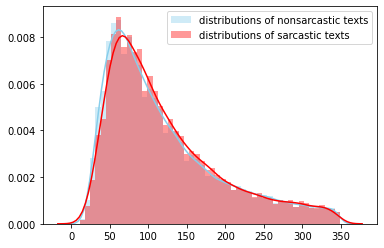

In [10]:
sns.distplot(len_list, color="skyblue", label="distributions of nonsarcastic texts")
sns.distplot(target_len_list, color="red", label="distributions of sarcastic texts")
plt.legend();

### WordCloud

In [11]:
wordcloud = WordCloud(
    background_color='black', 
    stopwords = stopwords.words("russian"),
    max_words = 200, 
    max_font_size = 100,
    width=800, 
    height=400
)

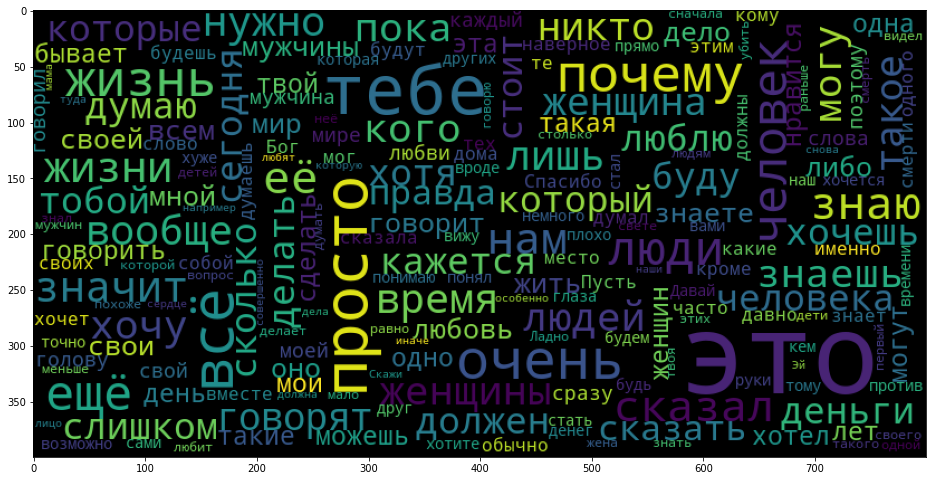

In [12]:
plt.figure(figsize=(16, 12))
wordcloud.generate(
    " ".join([s for s in df.loc[df['target'] == 1, 'quote'].values if isinstance(s, str)])
)
plt.imshow(wordcloud);

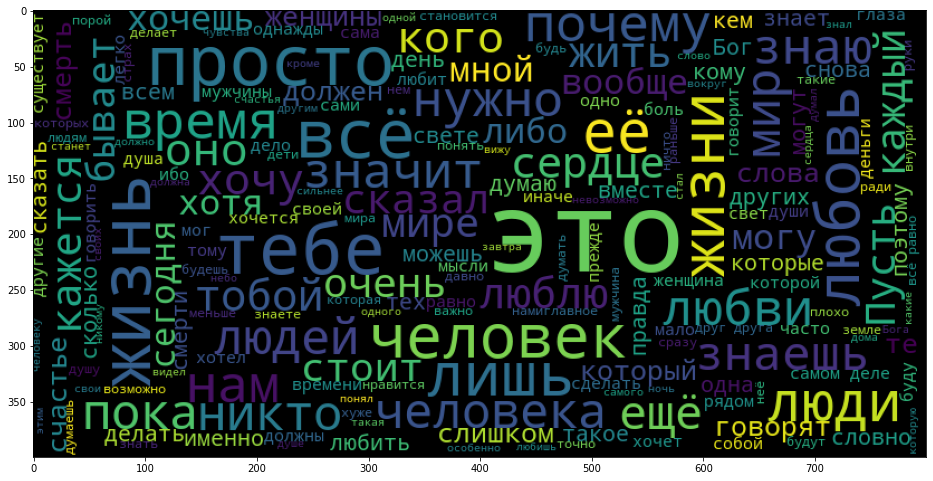

In [13]:
plt.figure(figsize=(16, 12))
wordcloud.generate(
    " ".join([s for s in df.loc[df['target'] == 0, 'quote'].values if isinstance(s, str)])
)
plt.imshow(wordcloud);

### Most popular authors

In [14]:
items = dict()
for item_list in df.author:
    if item_list:
        for item in item_list:
            if item in items.keys():
                items[item] += 1
            else:
                items[item] = 1
                
dict(sorted(items.items(), key=lambda item: item[1], reverse=True)[:20])

{'Станислав Ежи Лец': 2924,
 'Эрих Мария Ремарк': 1742,
 'Стивен Кинг': 1715,
 'Макс Фрай': 1506,
 'Уильям Шекспир': 1390,
 'Олег Рой': 1295,
 'Авессалом Подводный': 1234,
 'Эльчин Сафарли': 1223,
 'Харуки Мураками': 1206,
 'Терри Пратчетт': 1096,
 'Оскар Уайльд': 1090,
 'Пауло Коэльо': 1024,
 'Фредерик Бегбедер': 1010,
 'Фёдор Михайлович Достоевский': 954,
 'Дмитрий Емец': 930,
 'Януш Леон Вишневский': 909,
 'Сергей Лукьяненко': 894,
 'Чак Паланик': 874,
 'Виктор Гюго': 838,
 'Антон Павлович Чехов': 834}

### Delete punctuation

In [15]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [16]:
df.quote = df.quote.apply(remove_punctuations)

In [17]:
df.quote = df.quote.apply(lambda s: s.lower() if type(s) == str else s)

In [18]:
df['quote'] = df['quote'].apply(lambda s: ' '.join(s.split()))

### Add mystem

In [19]:
mystem = Mystem()

In [20]:
words_to_del = [' ', '\n'] + stopwords.words("russian")

In [21]:
def stem_text(text):
    text_list = mystem.lemmatize(" ".join(text.split()))
    return " ".join(
        [elem for elem in text_list if elem not in words_to_del]
    )

In [22]:
df.quote = df.quote.apply(stem_text)

In [23]:
df = df[df['quote'].apply(lambda x: len(x) > 10)]

### Get the top 20 common words:

In [24]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [25]:
common_words = get_top_n_words(df.quote, 20)
for word, freq in common_words:
    print(word, '--', freq)

человек который -- 4896
друг друг -- 4511
самый дело -- 2487
весь жизнь -- 2265
свой жизнь -- 2098
жизнь это -- 1644
каждый день -- 1503
весь время -- 1492
весь это -- 1458
человек мочь -- 1446
любовь это -- 1341
знать это -- 1301
весь мир -- 1290
это значить -- 1272
человек это -- 1266
который мочь -- 1259
конец конец -- 1146
наш жизнь -- 1107
это просто -- 1096
это самый -- 1095


In [26]:
common_words = get_top_n_words(df[df.target == 1]['quote'], 20)
for word, freq in common_words:
    print(word, '--', freq)

человек который -- 263
друг друг -- 197
весь время -- 130
самый дело -- 128
весь жизнь -- 102
весь это -- 92
знать это -- 87
свой жизнь -- 84
выходить замуж -- 80
женщина который -- 78
думать это -- 78
каждый день -- 77
хотеть сказать -- 77
это значить -- 71
человек это -- 69
это просто -- 67
это самый -- 66
это очень -- 65
сей пора -- 65
это твой -- 64
